In [759]:
import pandas as pd
import numpy as np
import re
from nltk.corpus import stopwords # Import the stop word list
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import RandomOverSampler

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Data Inspection Section

###  Purpose of this section: Ensure that data was loaded into the notebook properly. Examine dimensions of dataframe to verify new webscrapes were appended properly. 

In [760]:
df = pd.read_csv('/Users/ben/Desktop/DSI_GA_Materials/project_3/data/final_df_to48.csv')
# This one only TO 48 include 1-47 (including 1-48 nerfed scores/metrics) now we try 1-49 This nerfed as well which is curious try 1-50
df_optimal = pd.read_csv('/Users/ben/Desktop/DSI_GA_Materials/project_3/data/final_df_to48.csv') 
# Current dataframe load is best subset of all data as new additions are causing decreases in metrics, 
# Possible moderator lapse or even increase in number of imposters (trolls) could be cause. 
# These files were `final_df_to49` through `final_df_to51`
# Current optimal file : final_df_to48 (1/26)
# final_df_to52 also suboptimal

#### View the dimensions of the dataframe is ensure posts were scraped and carried over correctly. 

In [761]:
df.shape

(3397, 3)

In [762]:
df_optimal.shape

(3397, 3)

In [798]:
# Number of Democrat Posts
len(df[df['subreddit'] == 1])

1797

In [800]:
# Number of Republican Posts
len(df[df['subreddit'] == 0])

1600

#### The disparity between party post totals is minimal, proceed to cleaning section. 

# Preliminary Cleaning Section

### Purpose of this section:
1. Instantiate the `train-test-test` split
1. Clean the data using regular expressions and a custom censoring function
1. Create stopwords that will be used in the modeling section

In [763]:
# Create train_test_split.
# 90 train size
# Generate confusion matrices for these models after fitting and scoring. 

X_train, X_test, y_train, y_test = train_test_split(df['title'],
                                                    df['subreddit'],
                                                    train_size = 0.90,
                                                    random_state = 42)

In [764]:
def posts_to_words(train_data):
    # Function to convert a raw post to a string of words
    # The input is a single string (a raw subreddit title), and 
    # the output is a single string (a preprocessed subreddit post)
    
    # 1. Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", train_data)
    
    # 2. Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # 3. In Python, searching a set is much faster than searching
    # a list, so convert the stop words to a set.
    stops = set(stopwords.words('english'))
    
    # 4. Remove stop words.
    meaningful_words = [w for w in words if w not in stops]
    
    # 5. Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words))

total_posts = df.shape[0]
print(f'There are {total_posts} posts.')

# Initialize an empty list to hold the clean reviews.
clean_train_posts = []
clean_test_posts = []

print("Cleaning and parsing the training set subreddit posts...")

j = 0
for train_posts in X_train:
    # Convert review to words, then append to clean_train_reviews.
    clean_train_posts.append(posts_to_words(train_posts))
    
    # If the index is divisible by 1000, print a message
    if (j + 1) % 500 == 0:
        print(f'Post {j + 1} of {total_posts}.')
    
    j += 1

# Do the same for testing set.

print("Cleaning and parsing the testing set subreddit posts...")


There are 3397 posts.
Cleaning and parsing the training set subreddit posts...
Post 500 of 3397.
Post 1000 of 3397.
Post 1500 of 3397.
Post 2000 of 3397.
Post 2500 of 3397.
Post 3000 of 3397.
Cleaning and parsing the testing set subreddit posts...


In [765]:
# Censor function with regular expressions to eliminate variations of foul language
def censor(text, banned):
    for word in banned:
        text = re.sub(rf'\b{re.escape(word)}(?:\w*)\b', '*' * len(word), text, flags=re.IGNORECASE)
    return text
# Sample output
print(censor('Chick-chick-Chicken sandwich, I love a good chicken sandwich; vanilla ice cream dessert.', ['chick', 'cream']))

*****-*****-***** sandwich, I love a good ***** sandwich; vanilla ice ***** dessert.


#### `censor` function performs adequately and is utilized in the following block of code.

In [766]:

for test_posts in X_test:
    # Convert review to words, then append to clean_train_reviews.
    clean_test_posts.append(posts_to_words(test_posts))
    
    # If the index is divisible by 1000, print a message
    if (j + 1) % 1000 == 0:
        print(f'Post {j + 1} of {total_posts}.')
        
    j += 1

clean_train_posts

np.mean(len(clean_train_posts))

# Applying censor function to each element in clean_train_posts
censored_posts_train = [censor(post, ['shit', 'fuck']) if post else '' for post in clean_train_posts]
# Please forgive the authors foul language! 

# Print the censored posts - commented out to reduce notebook length
# for censored_post in censored_posts_train:
#     print(censored_post)

# Applying censor function to each element in clean_train_posts
censored_posts_test = [censor(post, ['shit', 'fuck']) if post else '' for post in clean_test_posts]

# Print the censored posts - Commented out to reduce notebook length
# for censored_post in censored_posts_test:
#     print(censored_post)

#### Note: Emojis are being turned into blank character (''); when `censor` function is applied these lines are completely wiped out. The loss is minimal and its effect negligible in total performance, as will be seen in the following sections. 

# Stopwords Section

#### Purpose: Gain a list of stopwords that will make a difference in the analysis. 

In [767]:
# Instantiate the transformer.
tvec = TfidfVectorizer()

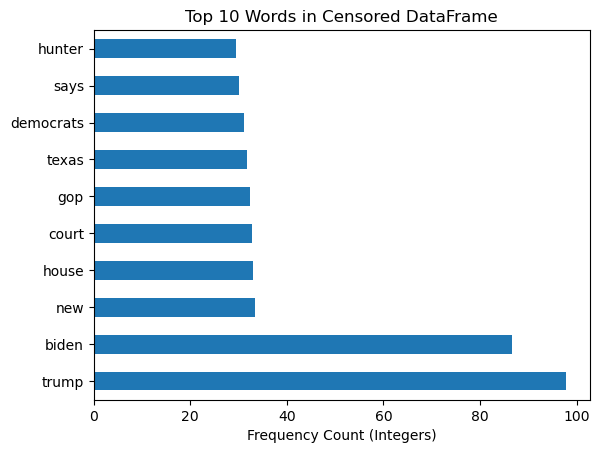

In [768]:
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(clean_train_posts).todense(), 
                          columns=tvec.get_feature_names_out())

# View top 50 occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');
plt.title('Top 10 Words in Censored DataFrame');
plt.xlabel('Frequency Count (Integers)');

#### A realistic interpretation of this bargraph would be that leaving these words in will provide important context within the subreddit posts, so creating a custom stopwords list and excluding them may not be beneficial. This was substantiated with gridsearch parameter analysis that has been removed from the final working version of this code. 

In [769]:
# Add your custom stopwords to the English stopwords list
english_stopwords = stopwords.words('english')
custom_stopwords  = [
    'trump', 'biden', 'new', 'gop', 'democrats', 'texas', 'house', 'court', 'republicans',
    'says', 'abortion', 'state', 'election', 'president', 'border', 'ballot', 'donald', 'hunter',
    'florida', 'us', 'haley', 'republican', 'supreme', 'people', 'could', 'iowa', 'campaign',
    'democracy', 'white', 'vote', 'santos', 'illegal', 'rep', 'case', 'colorado', 'joe', 'get',
    'voters', 'congress', 'george', 'democratic', 'right', 'nikki', 'would', 'america', 'senate',
    'poll', 'jan', 'bill', 'primary'
]

# Combine the two lists of stopwords using the + operator
combined_stopwords = english_stopwords + custom_stopwords

#### Previously, redelved into the regex aspect of things and worked with the `censor` function. Stopwords were explored but yielded no meaningful results and have been left in the code for viewership reference.

# Modeling Section

# Baseline accuracy
Calculate baseline accuracy in order to tell if model is better than null model (predicting the plurality class).

In [770]:
#null model dem 1 rep 0
df['subreddit'].value_counts(normalize=True)

subreddit
1    0.528996
0    0.471004
Name: proportion, dtype: float64

In [771]:
# Baseline prediction dem 1 rep 0
y_train.value_counts(normalize=True)

subreddit
1    0.524043
0    0.475957
Name: proportion, dtype: float64

In [772]:
print(f"Difference metric | {round(np.abs(np.mean(df['subreddit'])-np.mean(y_train)), 5)}")

Difference metric | 0.00495


Absolute difference: ($\sim0.5\%$). 

# Logistic Regression Section 

### Proceeded with `GridSearchCV` and found some optimal choices for CVec then utilized these parameters in a well-defined function along with Logistic Regression fitting.

In [773]:
# # Example pipeline 

# pipe3 = Pipeline([
#     ('cvec', CountVectorizer()),
#     ('lr',LogisticRegression())
# ])

# pipe4 = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('lr',LogisticRegression())
# ])

# pipe_params3 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#                'cvec__ngram_range': [(1,1), (1,2), (1,3)],
#                 'cvec__min_df': [0.00005, 0.0001],
#                 'cvec__max_df': [0.6,0.65,0.7],
#                'cvec__stop_words': [None, 'english','combined_stopwords']
#               }

# pipe_params4 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
#                'tvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
#                 'tvec__min_df': [0.00005, 0.0001],
#                 'tvec__max_df': [0.6,0.65,0.7],
#                 'tvec__stop_words': [None, 'english','combined_stopwords']
#               }

# # Instantiate GridSearchCV.

# gs3 = GridSearchCV(pipe3, # what object are we optimizing?
#                   param_grid=pipe_params3, # what parameters values are we searching?
#                   cv=5) # 5-fold cross-validation.

# gs4 = GridSearchCV(pipe4, # what object are we optimizing?
#                   param_grid=pipe_params4, # what parameters values are we searching?
#                   cv=5) # 5-fold cross-validation.

# gs3.fit(censored_posts_train, y_train)

# gs4.fit(censored_posts_train, y_train)

#### Performed a `GridSearch` (not shown) to find optimal features to create the best-performing CVEC, as this performed better than TVec in conjunction to the logistic regression during accuracy comparisons between test and train scores (not shown).

In [774]:
best_cvec = CountVectorizer(
    max_df=0.6, 
    max_features=9000, 
    min_df=5e-05, # The optimal value is 5e05
    ngram_range=(1, 2), 
    stop_words = None # The optimal parameter is None
)

During `GridSearch` it was revealed that optimal stopwords parameter was `None`, thus, the custom list of stopwords were not utilized. 

#### Transform the censored posts using the best performing CountVectorizer.

In [775]:
X_train_cvec = best_cvec.fit_transform(censored_posts_train)
X_test_cvec =  best_cvec.transform(censored_posts_test)

### Scale data

In [776]:
ss = StandardScaler(with_mean=False)

X_train_ss = ss.fit_transform(X_train_cvec)
X_test_ss = ss.transform(X_test_cvec)


## Optimize Logistic Regression by utilizing a GridSearch Algorithm

### Search for a better $C$ value, where $C$ is the inverse of regularization strength $\alpha$; inverse of regularization strength. A Higher $C$ value means lower regularization. Smaller $C$ value means higher regularization. Increase regularization because increasing regularization is a better technique than reducing the number of features to overcome the overfitting problem.

In [777]:
from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear'), param_grid, cv=5)
grid_search.fit(X_train_ss, y_train)

print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'C': 0.1}


### Optimize with the Oversampler - Will not proceed as there were only infinitesimally small benefits and the nature of data collection cannot be captured with an oversampler. Utilize SMOTE in BONUS section at the end of this notebook. 
#### In other words, adding more data through increasing webscrapes may produce certain data that will skew the model due to the nature of the data itself, so-called "imposters" of either political camp, and so oversampling would lead to an inadequate representation of the data.  

In [778]:
# Parameter grid for Logistic Regression
# param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100]}

# # Create a pipeline with RandomOverSampler and GridSearchCV
# pipe = make_pipeline(
#     RandomOverSampler(sampling_strategy="all", random_state=42),
#     GridSearchCV(
#         LogisticRegression(max_iter=10000, penalty='l1', solver='liblinear'),
#         param_grid,
#         cv=5
#     )
# )

# # Fit the pipeline
# pipe.fit(X_train_ss, y_train)

# # Access the best parameters found by GridSearchCV
# print("Best parameters: ", pipe.named_steps['gridsearchcv'].best_params_)

### Print out Train and Test Scores

In [779]:
print(f"Train Accuracy Score | {round(grid_search.score(X_train_ss, y_train),3)}")
print(f"Test Accuracy Score | {round(grid_search.score(X_test_ss, y_test),3)}")

Train Accuracy Score | 0.986
Test Accuracy Score | 0.909


TN: 125
FP: 20
FN: 11
TP: 184


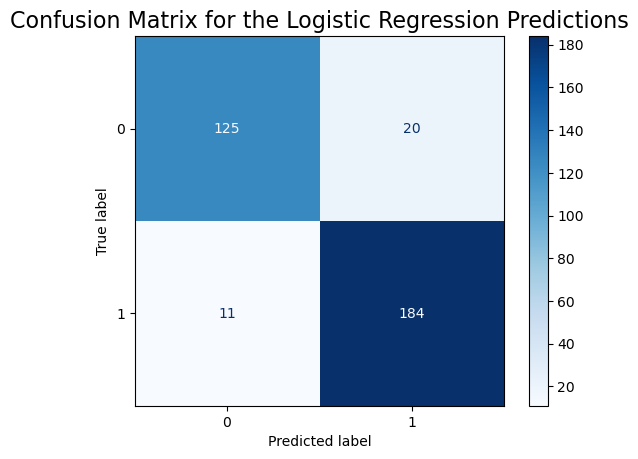

In [780]:
# Get predictions from optimal LR model
preds = grid_search.predict(X_test_ss)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

# Generate values of confusion matrix for reference
def find_cm(y_test, preds):
    tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()
    
    return f"TN: {tn}\nFP: {fp}\nFN: {fn}\nTP: {tp}" 
    
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_search, X_test_ss, y_test, cmap='Blues');
plt.title('Confusion Matrix for the Logistic Regression Predictions',fontsize=16, loc='center');

print(find_cm(y_test, preds))

### These figures will inform how the classification metrics results will materialize

In [781]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp/(tp+fn),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn/(tn+fp),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp+tn)/(tp+fp+tn+fn),3)}")
# Calculate Precision
print(f"Precision | {round(tp/(tp+fp),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp+fn)/(tp+fp+tn+fn),3)}")

Sensitivity | 0.944
Specificity | 0.862
Accuracy | 0.909
Precision | 0.902
Miscalculation Rate | 0.091


### Since the goal of the model is to prioritize sensitivity, this result is desired. 

In other words, the positive class is whether the post belonged to the `democrats` subreddit class, denoted by a $1$, therefore, the goal is the achieve a result that yields a high probability of correctly predicting an "actual" positive example. 

Precision is also also high, that is, the probability that the model is correct when it predicts an example to be in the positive class. In this value, a desired result is accomplished.

# Support Vector Machine (SVM) Section

### Disclaimer: This model performed well, and outperformed $\textit{Naive Bayes}$ statistical models and $\textit{logistic regression}$, with train in upper 90s and test in low 90s. The other models, aside from $\textit{logistic regression}$, have been excluded for brevity.  

#### Performed a `GridSearch` (not shown) to find optimal features to create the best-performing TVEC, as this performed better than CVec in conjunction to the SVM during accuracy comparisons between test and train scores (not shown).

In [782]:
# # Example pipeline 

# pipe3 = Pipeline([
#     ('cvec', CountVectorizer()),
#     ('svm',SVC())
# ])

# pipe4 = Pipeline([
#     ('tvec', TfidfVectorizer()),
#     ('svm',SVC())
# ])

# pipe_params3 = {'cvec__max_features': list(np.arange(5000, 10000, 1000)),
#                'cvec__ngram_range': [(1,1), (1,2), (1,3)],
#                 'cvec__min_df': [0.00005, 0.0001],
#                 'cvec__max_df': [0.6,0.65,0.7],
#                'cvec__stop_words': [None, 'english','combined_stopwords']
#               }

# pipe_params4 = {'tvec__max_features' : list(np.arange(5000, 10000, 1000)),
#                'tvec__ngram_range' : [(1, 1), (1, 2), (1,3)],
#                 'tvec__min_df': [0.00005, 0.0001],
#                 'tvec__max_df': [0.6,0.65,0.7],
#                 'tvec__stop_words': [None, 'english','combined_stopwords']
#               }

# # Instantiate GridSearchCV.

# gs3 = GridSearchCV(pipe3, # what object are we optimizing?
#                   param_grid=pipe_params3, # what parameters values are we searching?
#                   cv=5) # 5-fold cross-validation.

# gs4 = GridSearchCV(pipe4, # what object are we optimizing?
#                   param_grid=pipe_params4, # what parameters values are we searching?
#                   cv=5) # 5-fold cross-validation.

# gs3.fit(censored_posts_train, y_train)

# gs4.fit(censored_posts_train, y_train)

In [783]:
best_tvec = TfidfVectorizer(
    max_df=0.6, 
    max_features=8000, 
    min_df=5e-05,
    ngram_range=(1, 2), 
    stop_words = 'english'
)

#### Transform the censored posts using the best performing TFIDFVectorizer.

In [784]:
X_train_tvec = best_tvec.fit_transform(censored_posts_train)
X_test_tvec =  best_tvec.transform(censored_posts_test)

In [785]:
# Do not Use for this Model (Scores and Metrics Decreased)
# ss = StandardScaler(with_mean=False)

# X_train_ss = ss.fit_transform(X_train_tvec)
# X_test_ss = ss.transform(X_test_tvec)

In [786]:
# Define a parameter grid
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

# Create the grid search
grid_search_svm = GridSearchCV(SVC(), param_grid, cv=5)
grid_search_svm.fit(X_train_tvec, y_train)

# Print the best parameters
print("Best parameters: ", grid_search.best_params_)

Best parameters:  {'C': 0.1}


### Optimize with RandomOverSampler 
#### It performed poorly compared with regular gridsearch so keep grid_search_svm

In [787]:
# # Define a parameter grid for SVC
# param_grid_svm = {
#     'C': [0.001, 0.01, 0.1, 1, 10, 100],
#     'kernel': ['linear', 'rbf', 'poly'],
#     'degree': [2, 3, 4],  # Only applicable for 'poly' kernel
# }

# # Create the pipeline with RandomOverSampler and GridSearchCV for SVC
# pipe_svm = make_pipeline(
#     RandomOverSampler(sampling_strategy="all", random_state=42),
#     GridSearchCV(SVC(), param_grid_svm, cv=5)
# )

# # Fit the pipeline
# pipe_svm.fit(X_train_tvec, y_train)

# # Access the best parameters found by GridSearchCV for SVC
# print("Best parameters for SVC: ", pipe_svm.named_steps['gridsearchcv'].best_params_)

In [788]:
# print(f"Train score for SVM Tvec: {pipe_svm.score(X_train_tvec,y_train)}")
# print(f"Test score for SVM Tvec: {pipe_svm.score(X_test_tvec,y_test)}")

In [789]:
print(f"Train Accuracy Score | {round(grid_search_svm.score(X_train_tvec, y_train),3)}")
print(f"Test Accuracy Score | {round(grid_search_svm.score(X_test_tvec, y_test),3)}")

Train Accuracy Score | 0.995
Test Accuracy Score | 0.921


### These figures will inform how the classification metrics results will materialize

TN: 132
FP: 13
FN: 14
TP: 181


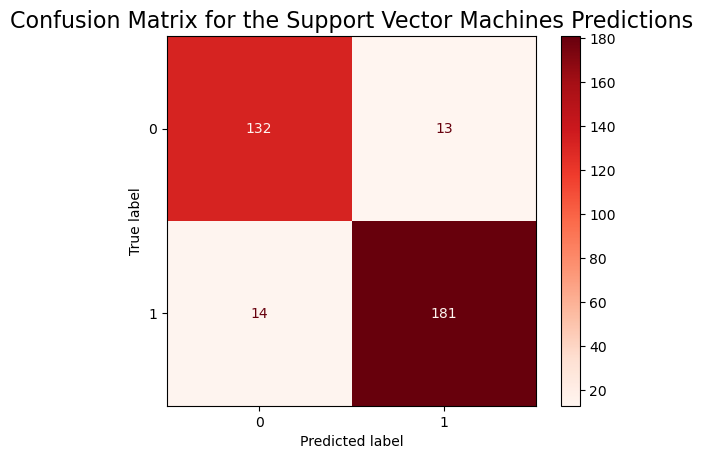

In [790]:
# Get predictions svm
preds_svm = grid_search_svm.predict(X_test_tvec)

# Save confusion matrix values
tn_svm, fp_svm, fn_svm, tp_svm = confusion_matrix(y_test, preds10).ravel()

# View confusion matrix
ConfusionMatrixDisplay.from_estimator(grid_search_svm, X_test_tvec, y_test, cmap='Reds');
plt.title('Confusion Matrix for the Support Vector Machines Predictions', fontsize=16, loc='center');

# Generate values of confusion matrix for reference
print(find_cm(y_test, preds_svm))

In [791]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp_svm/(tp_svm+fn_svm),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn_svm/(tn_svm+fp_svm),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp_svm+tn_svm)/(tp_svm+fp_svm+tn_svm+fn_svm),3)}")
# Calculate Precision
print(f"Precision | {round(tp_svm/(tp_svm+fp_svm),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp_svm+fn_svm)/(tp_svm+fp_svm+tn_svm+fn_svm),3)}")

Sensitivity | 0.928
Specificity | 0.91
Accuracy | 0.921
Precision | 0.933
Miscalculation Rate | 0.079


### Since the goal of the model is to prioritize sensitivity, this result is desired. 

In other words, the positive class is whether the post belonged to the `democrats` subreddit class, denoted by a $1$, therefore, the goal is to achieve a result that yields a high probability of correctly predicting an "actual" positive example. 

Precision is also high, that is, the probability that the model is correct when it predicts an example to be in the positive class. For this value, a desired outcome is accomplished.

Accuracy, the percentage of observations correctly predicted within the test class, has peaked at $90\%$, so another highly appealing result has been achieved. 

Here, $\textit{SVM}$ has outperformed $\textit{logistic regression}$ in nearly all of the aforementioned classification metrics; thus $\textit{SVM}$ is the optimal model at differentiating between the two subreddit classes. 

# Bonus Section: USE SMOTE

In [792]:
from imblearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Define a parameter grid for SVC
param_grid_svm = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel': ['linear', 'rbf', 'poly'],
    'degree': [2, 3, 4],  # Only applicable for 'poly' kernel
}

# Create a pipeline with SMOTE, SVC, and GridSearchCV
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('svm', GridSearchCV(SVC(), param_grid_svm, cv=5))
])

# Fit the pipeline
pipeline.fit(X_train_tvec, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test_tvec)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Access the best parameters found by GridSearchCV for SVC
print("Best parameters for SVC: ", pipeline.named_steps['svm'].best_params_)


Test Accuracy: 90.59%
Best parameters for SVC:  {'C': 1, 'degree': 2, 'kernel': 'poly'}


### Ended up performing worse than the other SVC

### Try with Logistic as well

In [793]:
# Define a parameter grid for Logistic Regression
param_grid_logreg = {
    'C': [0.001, 0.01, 0.1, 1],
    'penalty': ['l2'],
    'max_iter': [5000, 7500, 10000],
    'tol': [1e-3, 1e-4, 1e-5]
}

# Create a pipeline with SMOTE, Logistic Regression, and GridSearchCV
pipeline = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('logreg', GridSearchCV(LogisticRegression(max_iter=10000), param_grid_logreg, cv=5))
])

# Fit the pipeline
pipeline.fit(X_train_ss, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test_ss)

# Calculate and print the accuracy score
accuracy = accuracy_score(y_test, y_pred)
print("Test Accuracy: {:.2f}%".format(accuracy * 100))

# Access the best parameters found by GridSearchCV for Logistic Regression
print("Best parameters for Logistic Regression: ", pipeline.named_steps['logreg'].best_params_)

Test Accuracy: 91.18%
Best parameters for Logistic Regression:  {'C': 0.001, 'max_iter': 5000, 'penalty': 'l2', 'tol': 0.001}


### Ended up performing better than the other Log Reg

TN: 132
FP: 13
FN: 17
TP: 178


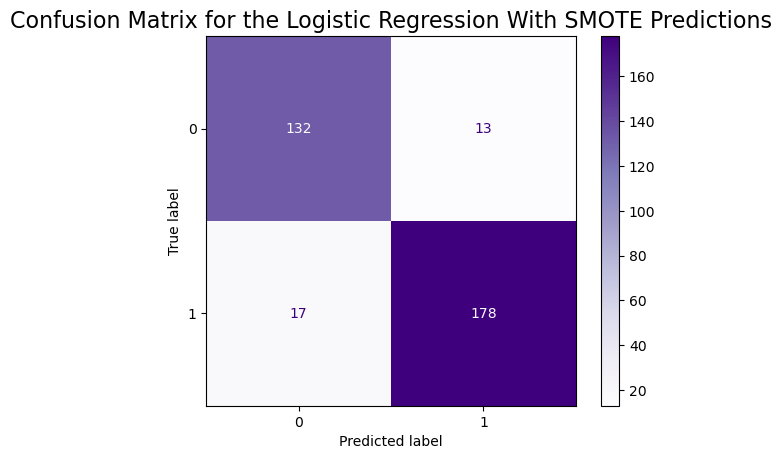

In [794]:
# View confusion matrix
ConfusionMatrixDisplay.from_estimator(pipeline, X_test_ss, y_test, cmap='Purples');
plt.title('Confusion Matrix for the Logistic Regression With SMOTE Predictions',fontsize=16, loc='center');

print(find_cm(y_test, y_pred))

In [795]:
tn_op_lr, fp_op_lr, fn_op_lr, tp_op_lr = confusion_matrix(y_test, y_pred).ravel()


In [796]:
# Calculate Sensitivity
print(f"Sensitivity | {round(tp_op_lr/(tp_op_lr+fn_op_lr),3)}")
# Calculate the Specificity
print(f"Specificity | {round(tn_op_lr/(tn_op_lr+fp_op_lr),3)}")
# Calculate Accuracy
print(f"Accuracy | {round((tp_op_lr+tn_op_lr)/(tp_op_lr+fp_op_lr+tn_op_lr+fn_op_lr),3)}")
# Calculate Precision
print(f"Precision | {round(tp_op_lr/(tp_op_lr+fp_op_lr),3)}")
# Calculate Miscalculation Rate
print(f"Miscalculation Rate | {round((fp_op_lr+fn_op_lr)/(tp_op_lr+fp_op_lr+tn_op_lr+fn_op_lr),3)}")

Sensitivity | 0.913
Specificity | 0.91
Accuracy | 0.912
Precision | 0.932
Miscalculation Rate | 0.088


### In this BONUS Section, `SMOTE` was utilized to attempt further optimization. Therefore, although the model with `SMOTE` and $\textit{logistic\,regression}$ outperformed the original $\textit{logistic\,regression}$ model, it still did not outperform $\textit{SVM}$. 